In [7]:
#SRCでの各条件での正答率を出したもの
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io
import pandas as pd
from pandas import DataFrame as dframe
import cvxpy as cv

In [8]:
def Dic(feat_l_tr,feat_r_tr): #入力の配列は2次元配列である必要がある
    feat_tr = np.concatenate([feat_l_tr, feat_r_tr],0)
    return feat_tr

In [9]:
def SRC(feat_tr_dic,feat_l_te,matrix_index):
    answer = np.zeros(feat_l_te.shape[1])
    #スパース性を格納する行列
    SRC_Cla = np.zeros((feat_tr_dic.shape[1], feat_l_te.shape[1]))
    #leftクラスのみのスパース性を格納するための行列
    SRC_l_Cla = np.zeros((feat_tr_dic.shape[1], feat_l_te.shape[1]))
    #rightクラスのみのスパース性を格納するための行列
    SRC_r_Cla = np.zeros((feat_tr_dic.shape[1], feat_l_te.shape[1]))
    for i in range(feat_l_te.shape[1]):
        x = cv.Variable((feat_tr_dic.shape[1],1)) #目的関数の次元
        objective = cv.Minimize(cv.norm(x,1))
        constraints = [feat_l_te[:,i,np.newaxis] == feat_tr_dic@x]
        prob = cv.Problem(objective, constraints)
        result = prob.solve()
        #classVariableから値を取るためには.valueを付け、次元も削減
        SRC_Cla[:,i] = np.squeeze(x.value)
        #各クラスに関連する表現ベクトルの値を抜き出す
        #lは仕切りの値
        l = 0
        j = 0
        while j < matrix_index.shape[0]-1:
            SRC_l_Cla[l:l+matrix_index[j],i] = SRC_Cla[l:l+matrix_index[j],i]     
            l = l + matrix_index[j]
            j = j + 1
            SRC_r_Cla[l:l+matrix_index[j],i] = SRC_Cla[l:l+matrix_index[j],i]
            l = l + matrix_index[j]
            j = j + 1
    #パラメータを使って擬似的に各クラスのテスト信号の特徴ベクトルを作成
    dout_feat_l_te = np.zeros((feat_l_te.shape[0], feat_l_te.shape[1]))
    dout_feat_r_te = np.zeros((feat_l_te.shape[0], feat_l_te.shape[1])) 
    for i in range(feat_l_te.shape[1]):
        dout_feat_l_te[:,i] = feat_tr_dic@SRC_l_Cla[:,i]
    for i in range(feat_l_te.shape[1]):
        dout_feat_r_te[:,i] = feat_tr_dic@SRC_r_Cla[:,i]
    #作成した擬似特徴ベクトルとの残差を求める
    R_l =  np.zeros((feat_l_te.shape[0], feat_l_te.shape[1])) #残差を格納するための配列
    R_r =  np.zeros((feat_l_te.shape[0], feat_l_te.shape[1]))  
    #残差を比べてクラスを割り当てる
    for i in range(feat_l_te.shape[1]):
        R_l[:,i] = feat_l_te[:,i]-dout_feat_l_te[:,i]
        R_r[:,i] = feat_l_te[:,i]-dout_feat_r_te[:,i]
        if np.linalg.norm(R_l[:,i], ord=2) < np.linalg.norm(R_r[:,i], ord=2):
            answer[i] = 1
        elif np.linalg.norm(R_l[:,i], ord=2) > np.linalg.norm(R_r[:,i], ord=2):
            answer[i] = 2
    return answer

In [10]:
def SRC_test(filename1,filename2,filename3,filename4,C1_K1,C2_K1,C1_K2,C2_K2,C1_K3,C2_K3):
    #対象被験者の特徴ベクトル(トレーニングデータ＆テストデータ)をMATLAB(自身で作成)から入手    
    feat_C1 = np.loadtxt(filename1,delimiter=",")
    feat_C2 = np.loadtxt(filename2,delimiter=",")
    feat_Test_C1 = np.loadtxt(filename3,delimiter=",")
    feat_Test_C2 = np.loadtxt(filename4,delimiter=",")
    #非対象被験者の特徴ベクトルをMATLABから入手
    feat_C1_K1 = np.loadtxt(C1_K1,delimiter=",")
    feat_C2_K1 = np.loadtxt(C2_K1,delimiter=",")
    feat_C1_K2 = np.loadtxt(C1_K2,delimiter=",")
    feat_C2_K2 = np.loadtxt(C1_K2,delimiter=",")
    feat_C1_K3 = np.loadtxt(C1_K3,delimiter=",")
    feat_C2_K3 = np.loadtxt(C1_K3,delimiter=",")

    #対象被験者の各クラスのトレーニングデータから取得した特徴ベクトルを結合
    feat_tr = Dic(feat_C1,feat_C2)
    #非対象被験者の特徴ベクトルも同様の処理を行う
    feat_tr_K1 = Dic(feat_C1_K1,feat_C2_K1)
    feat_tr_K2 = Dic(feat_C1_K2,feat_C2_K2)
    feat_tr_K3 = Dic(feat_C1_K3,feat_C2_K3)

    #それぞれの特徴ベクトルをつなげる
    #この時、2M×Nの行列にするために転置させる(2Mは特徴ベクトルの次元、Nはスパース表現を推定するために使用した特徴ベクトルの総数)
    feat_tr_dic_1 = Dic(feat_tr,feat_tr_K1)
    feat_tr_dic_2 = Dic(feat_tr_dic_1,feat_tr_K2)
    feat_tr_dic = Dic(feat_tr_dic_2,feat_tr_K3).T
    #feat_tr_dicはすべての特徴ベクトルをつなげたもの
    #テストデータの特徴ベクトルも2Mが行になるように転置させる
    feat_l_te = feat_Test_C1;
    feat_r_te = feat_Test_C2;
    feat_l_te = feat_l_te.T
    feat_r_te = feat_r_te.T
    #各被験者の各クラスの特徴ベクトルの数を格納する(各クラスのみのスパース性を格納するための行列作成に使用)
    matrix_index = np.array([feat_C1.shape[0],feat_C2.shape[0],feat_C1_K1.shape[0],feat_C2_K1.shape[0],feat_C1_K2.shape[0],feat_C2_K2.shape[0],
                        feat_C1_K3.shape[0],feat_C2_K3.shape[0]])
    answer1 = SRC(feat_tr_dic,feat_l_te,matrix_index)
    answer2 = SRC(feat_tr_dic,feat_r_te,matrix_index)
    x1 = 0
    x2 = 0
    for i in range(answer1.shape[0]):
        if answer1[i] == 1:
            x1 = x1 + 1
        if answer2[i] == 2:
            x2 = x2 + 1
    temp = ((x1+x2)/(answer1.shape[0]+answer2.shape[0]))*100
    temp1 = ((x1)/(answer1.shape[0]))*100
    temp2 = ((x2)/(answer2.shape[0]))*100
                    
    return temp,temp1,temp2

In [11]:
#DataFrameで表示したときの各列と行のラベルを設定
pd.options.display.float_format = '{:.1f}'.format
name1 = ["1","2","3","4","5","6"]
name2 = ["1","2","3"]
feature1 = ["全体","左","右"]
feature2 = ["全体","右","足"]

In [12]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A01T_20.txt","feat_2a_250Hz_20/feat_right_A01T_20.txt","feat_2a_250Hz_20/feat_test_left_A01E.txt","feat_2a_250Hz_20/feat_test_right_A01E.txt"
                           ,"feat_2a_250Hz_30/feat_left_A02T_30.txt","feat_2a_250Hz_30/feat_right_A02T_30.txt","feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A02T_20.txt","feat_2a_250Hz_20/feat_right_A02T_20.txt","feat_2a_250Hz_20/feat_test_left_A02E.txt","feat_2a_250Hz_20/feat_test_right_A02E.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A03T_20.txt","feat_2a_250Hz_20/feat_right_A03T_20.txt","feat_2a_250Hz_20/feat_test_left_A03E.txt","feat_2a_250Hz_20/feat_test_right_A03E.txt"
                           ,"feat_2a_250Hz_30/feat_left_A02T_30.txt","feat_2a_250Hz_30/feat_right_A02T_30.txt","feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A07T_20.txt","feat_2a_250Hz_20/feat_right_A07T_20.txt","feat_2a_250Hz_20/feat_test_left_A07E.txt","feat_2a_250Hz_20/feat_test_right_A07E.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A08T_20.txt","feat_2a_250Hz_20/feat_right_A08T_20.txt","feat_2a_250Hz_20/feat_test_left_A08E.txt","feat_2a_250Hz_20/feat_test_right_A08E.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A09T_20.txt","feat_2a_250Hz_20/feat_right_A09T_20.txt","feat_2a_250Hz_20/feat_test_left_A09E.txt","feat_2a_250Hz_20/feat_test_right_A09E.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A08T_30.txt","feat_2a_250Hz_30/feat_right_A08T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_1 = probability.reshape([6, 3])
df = pd.DataFrame(probability_1,columns=feature1,index=name1)
#df.to_csv("pandas_test.csv")
df

,全体,左,右
1,50.0,0.0,100.0
2,50.0,0.0,100.0
3,50.0,100.0,0.0
4,62.0,48.0,76.0
5,50.0,100.0,0.0
6,50.0,0.0,100.0


In [7]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A01T_20.txt","feat_2a_250Hz_20/feat_right_A01T_20.txt","feat_2a_250Hz_20/feat_test_left_A01E.txt","feat_2a_250Hz_20/feat_test_right_A01E.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A02T_30.txt","feat_2a_250Hz_30_2/feat_right_A02T_30.txt","feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A02T_20.txt","feat_2a_250Hz_20/feat_right_A02T_20.txt","feat_2a_250Hz_20/feat_test_left_A02E.txt","feat_2a_250Hz_20/feat_test_right_A02E.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A03T_20.txt","feat_2a_250Hz_20/feat_right_A03T_20.txt","feat_2a_250Hz_20/feat_test_left_A03E.txt","feat_2a_250Hz_20/feat_test_right_A03E.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A02T_30.txt","feat_2a_250Hz_30_2/feat_right_A02T_30.txt","feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A07T_20.txt","feat_2a_250Hz_20/feat_right_A07T_20.txt","feat_2a_250Hz_20/feat_test_left_A07E.txt","feat_2a_250Hz_20/feat_test_right_A07E.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A08T_20.txt","feat_2a_250Hz_20/feat_right_A08T_20.txt","feat_2a_250Hz_20/feat_test_left_A08E.txt","feat_2a_250Hz_20/feat_test_right_A08E.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A09T_20.txt","feat_2a_250Hz_20/feat_right_A09T_20.txt","feat_2a_250Hz_20/feat_test_left_A09E.txt","feat_2a_250Hz_20/feat_test_right_A09E.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A08T_30.txt","feat_2a_250Hz_30_2/feat_right_A08T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_2 = probability.reshape([6, 3])
df = pd.DataFrame(probability_2,columns=feature1,index=name1)
#df.to_csv("pandas_test.csv")
df

,全体,左,右
1,45.0,80.0,10.0
2,57.0,72.0,42.0
3,55.0,78.0,32.0
4,47.0,48.0,46.0
5,47.0,4.0,90.0
6,59.0,90.0,28.0


In [8]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A01T_20.txt","feat_2a_250Hz_20/feat_right_A01T_20.txt","feat_2a_250Hz_20/feat_test_left_A01E.txt","feat_2a_250Hz_20/feat_test_right_A01E.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A02T_30.txt","feat_2a_250Hz_30_3/feat_right_A02T_30.txt","feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A02T_20.txt","feat_2a_250Hz_20/feat_right_A02T_20.txt","feat_2a_250Hz_20/feat_test_left_A02E.txt","feat_2a_250Hz_20/feat_test_right_A02E.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A03T_20.txt","feat_2a_250Hz_20/feat_right_A03T_20.txt","feat_2a_250Hz_20/feat_test_left_A03E.txt","feat_2a_250Hz_20/feat_test_right_A03E.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A02T_30.txt","feat_2a_250Hz_30_3/feat_right_A02T_30.txt","feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_30_3/feat_left_A07T_30.txt","feat_2a_250Hz_30_3/feat_right_A07T_30.txt","feat_2a_250Hz_20/feat_test_left_A07E.txt","feat_2a_250Hz_20/feat_test_right_A07E.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A08T_20.txt","feat_2a_250Hz_20/feat_right_A08T_20.txt","feat_2a_250Hz_20/feat_test_left_A08E.txt","feat_2a_250Hz_20/feat_test_right_A08E.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A09T_20.txt","feat_2a_250Hz_20/feat_right_A09T_20.txt","feat_2a_250Hz_20/feat_test_left_A09E.txt","feat_2a_250Hz_20/feat_test_right_A09E.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A08T_30.txt","feat_2a_250Hz_30_3/feat_right_A08T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_3 = probability.reshape([6, 3])
df = pd.DataFrame(probability_3,columns=feature1,index=name1)
#df.to_csv("pandas_test.csv")
df

,全体,左,右
1,44.0,66.0,22.0
2,52.0,24.0,80.0
3,56.0,84.0,28.0
4,52.0,4.0,100.0
5,47.0,86.0,8.0
6,59.0,64.0,54.0


In [9]:
p_average_250Hz = (probability_1+probability_2+probability_3)/3
df = pd.DataFrame(p_average_250Hz,columns=feature1,index=name1)
#df.to_csv("pandas_test.csv")
df

,全体,左,右
1,45.3,75.3,15.3
2,53.0,64.7,41.3
3,56.3,82.0,30.7
4,50.0,50.0,50.0
5,48.7,34.0,63.3
6,60.3,78.7,42.0


In [10]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_20/feat_left_A01T_20.txt","feat_2a_125Hz_20/feat_right_A01T_20.txt","feat_2a_125Hz_20/feat_test_left_A01E.txt","feat_2a_125Hz_20/feat_test_right_A01E.txt"
                           ,"feat_2a_125Hz_30/feat_left_A02T_30.txt","feat_2a_125Hz_30/feat_right_A02T_30.txt","feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_20/feat_left_A02T_20.txt","feat_2a_125Hz_20/feat_right_A02T_20.txt","feat_2a_125Hz_20/feat_test_left_A02E.txt","feat_2a_125Hz_20/feat_test_right_A02E.txt"
                           ,"feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt","feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_20/feat_left_A03T_20.txt","feat_2a_125Hz_20/feat_right_A03T_20.txt","feat_2a_125Hz_20/feat_test_left_A03E.txt","feat_2a_125Hz_20/feat_test_right_A03E.txt"
                           ,"feat_2a_125Hz_30/feat_left_A02T_30.txt","feat_2a_125Hz_30/feat_right_A02T_30.txt","feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_20/feat_left_A07T_20.txt","feat_2a_125Hz_20/feat_right_A07T_20.txt","feat_2a_125Hz_20/feat_test_left_A07E.txt","feat_2a_125Hz_20/feat_test_right_A07E.txt"
                           ,"feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt","feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_20/feat_left_A08T_20.txt","feat_2a_125Hz_20/feat_right_A08T_20.txt","feat_2a_125Hz_20/feat_test_left_A08E.txt","feat_2a_125Hz_20/feat_test_right_A08E.txt"
                           ,"feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt","feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_20/feat_left_A09T_20.txt","feat_2a_125Hz_20/feat_right_A09T_20.txt","feat_2a_125Hz_20/feat_test_left_A09E.txt","feat_2a_125Hz_20/feat_test_right_A09E.txt"
                           ,"feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt","feat_2a_125Hz_30/feat_left_A08T_30.txt","feat_2a_125Hz_30/feat_right_A08T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_1 = probability.reshape([6, 3])
df = pd.DataFrame(probability_1,columns=feature1,index=name1)
#df.to_csv("pandas_test.csv")
df

,全体,左,右
1,54.0,66.0,42.0
2,49.0,96.0,2.0
3,48.0,90.0,6.0
4,50.0,86.0,14.0
5,51.0,74.0,28.0
6,49.0,2.0,96.0


In [11]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_20/feat_left_A01T_20.txt","feat_2a_125Hz_20/feat_right_A01T_20.txt","feat_2a_125Hz_20/feat_test_left_A01E.txt","feat_2a_125Hz_20/feat_test_right_A01E.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A02T_30.txt","feat_2a_125Hz_30_2/feat_right_A02T_30.txt","feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_20/feat_left_A02T_20.txt","feat_2a_125Hz_20/feat_right_A02T_20.txt","feat_2a_125Hz_20/feat_test_left_A02E.txt","feat_2a_125Hz_20/feat_test_right_A02E.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_20/feat_left_A03T_20.txt","feat_2a_125Hz_20/feat_right_A03T_20.txt","feat_2a_125Hz_20/feat_test_left_A03E.txt","feat_2a_125Hz_20/feat_test_right_A03E.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A02T_30.txt","feat_2a_125Hz_30_2/feat_right_A02T_30.txt","feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_20/feat_left_A07T_20.txt","feat_2a_125Hz_20/feat_right_A07T_20.txt","feat_2a_125Hz_20/feat_test_left_A07E.txt","feat_2a_125Hz_20/feat_test_right_A07E.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_20/feat_left_A08T_20.txt","feat_2a_125Hz_20/feat_right_A08T_20.txt","feat_2a_125Hz_20/feat_test_left_A08E.txt","feat_2a_125Hz_20/feat_test_right_A08E.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_20/feat_left_A09T_20.txt","feat_2a_125Hz_20/feat_right_A09T_20.txt","feat_2a_125Hz_20/feat_test_left_A09E.txt","feat_2a_125Hz_20/feat_test_right_A09E.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A06T_30.txt","feat_2a_125Hz_30_2/feat_right_A06T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_2 = probability.reshape([6, 3])
df = pd.DataFrame(probability_2,columns=feature1,index=name1)
#df.to_csv("pandas_test.csv")
df

,全体,左,右
1,47.0,38.0,56.0
2,49.0,98.0,0.0
3,47.0,82.0,12.0
4,51.0,92.0,10.0
5,54.0,72.0,36.0
6,52.0,8.0,96.0


In [12]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_20/feat_left_A01T_20.txt","feat_2a_125Hz_20/feat_right_A01T_20.txt","feat_2a_125Hz_20/feat_test_left_A01E.txt","feat_2a_125Hz_20/feat_test_right_A01E.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A02T_30.txt","feat_2a_125Hz_30_3/feat_right_A02T_30.txt","feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_20/feat_left_A02T_20.txt","feat_2a_125Hz_20/feat_right_A02T_20.txt","feat_2a_125Hz_20/feat_test_left_A02E.txt","feat_2a_125Hz_20/feat_test_right_A02E.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_20/feat_left_A03T_20.txt","feat_2a_125Hz_20/feat_right_A03T_20.txt","feat_2a_125Hz_20/feat_test_left_A03E.txt","feat_2a_125Hz_20/feat_test_right_A03E.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A02T_30.txt","feat_2a_125Hz_30_3/feat_right_A02T_30.txt","feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_20/feat_left_A07T_20.txt","feat_2a_125Hz_20/feat_right_A07T_20.txt","feat_2a_125Hz_20/feat_test_left_A07E.txt","feat_2a_125Hz_20/feat_test_right_A07E.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_20/feat_left_A08T_20.txt","feat_2a_125Hz_20/feat_right_A08T_20.txt","feat_2a_125Hz_20/feat_test_left_A08E.txt","feat_2a_125Hz_20/feat_test_right_A08E.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_20/feat_left_A09T_20.txt","feat_2a_125Hz_20/feat_right_A09T_20.txt","feat_2a_125Hz_20/feat_test_left_A09E.txt","feat_2a_125Hz_20/feat_test_right_A09E.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A08T_30.txt","feat_2a_125Hz_30_3/feat_right_A08T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_3 = probability.reshape([6, 3])
df = pd.DataFrame(probability_3,columns=feature1,index=name1)
#df.to_csv("pandas_test.csv")
df

,全体,左,右
1,53.0,62.0,44.0
2,49.0,94.0,4.0
3,51.0,100.0,2.0
4,52.0,86.0,18.0
5,54.0,74.0,34.0
6,50.0,8.0,92.0


In [13]:
p_average_125Hz = (probability_1+probability_2+probability_3)/3
df = pd.DataFrame(p_average_125Hz,columns=feature1,index=name1)
#df.to_csv("pandas_test.csv")
df

,全体,左,右
1,51.3,55.3,47.3
2,49.0,96.0,2.0
3,48.7,90.7,6.7
4,51.0,88.0,14.0
5,53.0,73.3,32.7
6,50.3,6.0,94.7


In [14]:
a_20 = 0; a_30 = 0;
for i in range(6):
    a_20 = a_20 + p_average_250Hz[i,0] 
    a_30 = a_30 + p_average_125Hz[i,0] 
    
a_20 = a_20/6
a_30 = a_30/6
print(a_20,a_30)

52.27777777777778 50.55555555555555


[[51.33333333 49.         48.66666667 51.         53.         50.33333333]
 [45.33333333 53.         56.33333333 50.         48.66666667 60.33333333]]


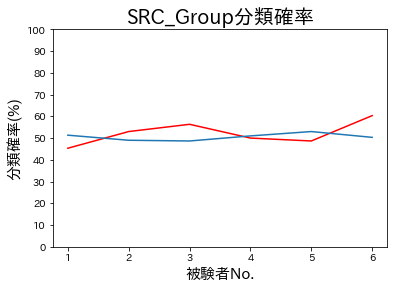

In [15]:
import matplotlib.pyplot as plt
import japanize_matplotlib
y = np.array([])
x = np.arange(1, 7, step=1)
y = np.append(p_average_250Hz[:,0],y)
y = np.append(p_average_125Hz[:,0],y)
y = y.reshape([2,6])
print(y)
plt.plot(x,y[1],"red")
plt.plot(x,y[0])
plt.title("SRC_Group分類確率", {"fontsize":20})
plt.xlabel("被験者No.", {"fontsize":15})
plt.ylabel("分類確率(%)", {"fontsize":15})
plt.xticks(np.arange(1, 7, step=1))
plt.yticks(np.arange(0, 110, step=10))
plt.savefig("2a_SRC_group_probability_K3.pdf")
plt.show()

In [16]:
#train=30,test=50で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_4a_1000Hz_20/feat_right_aa_20.txt","feat_4a_1000Hz_20/feat_foot_aa_20.txt","feat_4a_1000Hz_20/feat_test_right_aa.txt","feat_4a_1000Hz_20/feat_test_foot_aa.txt"
                           ,"feat_4a_1000Hz_30/feat_right_av_30.txt","feat_4a_1000Hz_30/feat_foot_av_30.txt","feat_4a_1000Hz_30/feat_right_al_30.txt","feat_4a_1000Hz_30/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30/feat_right_aw_30.txt","feat_4a_1000Hz_30/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_4a_1000Hz_20/feat_right_av_20.txt","feat_4a_1000Hz_20/feat_foot_av_20.txt","feat_4a_1000Hz_20/feat_test_right_av.txt","feat_4a_1000Hz_20/feat_test_foot_av.txt"
                           ,"feat_4a_1000Hz_30/feat_right_aa_30.txt","feat_4a_1000Hz_30/feat_foot_aa_30.txt","feat_4a_1000Hz_30/feat_right_al_30.txt","feat_4a_1000Hz_30/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30/feat_right_aw_30.txt","feat_4a_1000Hz_30/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_4a_1000Hz_20/feat_right_aw_20.txt","feat_4a_1000Hz_20/feat_foot_aw_20.txt","feat_4a_1000Hz_20/feat_test_right_aw.txt","feat_4a_1000Hz_20/feat_test_foot_aw.txt"
                           ,"feat_4a_1000Hz_30/feat_right_aa_30.txt","feat_4a_1000Hz_30/feat_foot_aa_30.txt","feat_4a_1000Hz_30/feat_right_al_30.txt","feat_4a_1000Hz_30/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30/feat_right_av_30.txt","feat_4a_1000Hz_30/feat_foot_av_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_1 = probability.reshape([3, 3])
df = pd.DataFrame(probability_1,columns=feature1,index=name2)
#df.to_csv("pandas_test.csv")
df

,全体,左,右
1,50.0,90.0,10.0
2,46.0,32.0,60.0
3,60.0,78.0,42.0


In [17]:
#train=30,test=50で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_4a_1000Hz_20/feat_right_aa_20.txt","feat_4a_1000Hz_20/feat_foot_aa_20.txt","feat_4a_1000Hz_20/feat_test_right_aa.txt","feat_4a_1000Hz_20/feat_test_foot_aa.txt"
                           ,"feat_4a_1000Hz_30_2/feat_right_av_30.txt","feat_4a_1000Hz_30_2/feat_foot_av_30.txt","feat_4a_1000Hz_30_2/feat_right_al_30.txt","feat_4a_1000Hz_30_2/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30_2/feat_right_aw_30.txt","feat_4a_1000Hz_30_2/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_4a_1000Hz_20/feat_right_av_20.txt","feat_4a_1000Hz_20/feat_foot_av_20.txt","feat_4a_1000Hz_20/feat_test_right_av.txt","feat_4a_1000Hz_20/feat_test_foot_av.txt"
                           ,"feat_4a_1000Hz_30_2/feat_right_aa_30.txt","feat_4a_1000Hz_30_2/feat_foot_aa_30.txt","feat_4a_1000Hz_30_2/feat_right_al_30.txt","feat_4a_1000Hz_30_2/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30_2/feat_right_aw_30.txt","feat_4a_1000Hz_30_2/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_4a_1000Hz_20/feat_right_aw_20.txt","feat_4a_1000Hz_20/feat_foot_aw_20.txt","feat_4a_1000Hz_20/feat_test_right_aw.txt","feat_4a_1000Hz_20/feat_test_foot_aw.txt"
                           ,"feat_4a_1000Hz_30_2/feat_right_aa_30.txt","feat_4a_1000Hz_30_2/feat_foot_aa_30.txt","feat_4a_1000Hz_30_2/feat_right_al_30.txt","feat_4a_1000Hz_30_2/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30_2/feat_right_av_30.txt","feat_4a_1000Hz_30_2/feat_foot_av_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_2 = probability.reshape([3, 3])
df = pd.DataFrame(probability_2,columns=feature1,index=name2)
#df.to_csv("pandas_test.csv")
df

,全体,左,右
1,52.0,98.0,6.0
2,42.0,22.0,62.0
3,63.0,74.0,52.0


In [18]:
#train=30,test=50で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_4a_1000Hz_20/feat_right_aa_20.txt","feat_4a_1000Hz_20/feat_foot_aa_20.txt","feat_4a_1000Hz_20/feat_test_right_aa.txt","feat_4a_1000Hz_20/feat_test_foot_aa.txt"
                           ,"feat_4a_1000Hz_30_3/feat_right_av_30.txt","feat_4a_1000Hz_30_3/feat_foot_av_30.txt","feat_4a_1000Hz_30_3/feat_right_al_30.txt","feat_4a_1000Hz_30_3/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30_3/feat_right_aw_30.txt","feat_4a_1000Hz_30_3/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_4a_1000Hz_20/feat_right_av_20.txt","feat_4a_1000Hz_20/feat_foot_av_20.txt","feat_4a_1000Hz_20/feat_test_right_av.txt","feat_4a_1000Hz_20/feat_test_foot_av.txt"
                           ,"feat_4a_1000Hz_30_3/feat_right_aa_30.txt","feat_4a_1000Hz_30_3/feat_foot_aa_30.txt","feat_4a_1000Hz_30_3/feat_right_al_30.txt","feat_4a_1000Hz_30_3/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30_3/feat_right_aw_30.txt","feat_4a_1000Hz_30_3/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_4a_1000Hz_20/feat_right_aw_20.txt","feat_4a_1000Hz_20/feat_foot_aw_20.txt","feat_4a_1000Hz_20/feat_test_right_aw.txt","feat_4a_1000Hz_20/feat_test_foot_aw.txt"
                           ,"feat_4a_1000Hz_30_3/feat_right_aa_30.txt","feat_4a_1000Hz_30_3/feat_foot_aa_30.txt","feat_4a_1000Hz_30_3/feat_right_al_30.txt","feat_4a_1000Hz_30_3/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30_3/feat_right_av_30.txt","feat_4a_1000Hz_30_3/feat_foot_av_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_3 = probability.reshape([3, 3])
df = pd.DataFrame(probability_3,columns=feature1,index=name2)
#df.to_csv("pandas_test.csv")
df

,全体,左,右
1,50.0,92.0,8.0
2,43.0,6.0,80.0
3,62.0,66.0,58.0


In [19]:
p_average_1000Hz = (probability_1+probability_2+probability_3)/3
df = pd.DataFrame(p_average_1000Hz,columns=feature1,index=name2)
#df.to_csv("pandas_test.csv")
df

,全体,左,右
1,50.7,93.3,8.0
2,43.7,20.0,67.3
3,61.7,72.7,50.7


In [20]:
#train=30,test=50で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_4a_100Hz_20/feat_right_aa_20.txt","feat_4a_100Hz_20/feat_foot_aa_20.txt","feat_4a_100Hz_20/feat_test_right_aa.txt","feat_4a_100Hz_20/feat_test_foot_aa.txt"
                           ,"feat_4a_100Hz_30/feat_right_av_30.txt","feat_4a_100Hz_30/feat_foot_av_30.txt","feat_4a_100Hz_30/feat_right_al_30.txt","feat_4a_100Hz_30/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30/feat_right_aw_30.txt","feat_4a_100Hz_30/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_4a_100Hz_20/feat_right_av_20.txt","feat_4a_100Hz_20/feat_foot_av_20.txt","feat_4a_100Hz_20/feat_test_right_av.txt","feat_4a_100Hz_20/feat_test_foot_av.txt"
                           ,"feat_4a_100Hz_30/feat_right_aa_30.txt","feat_4a_100Hz_30/feat_foot_aa_30.txt","feat_4a_100Hz_30/feat_right_al_30.txt","feat_4a_100Hz_30/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30/feat_right_aw_30.txt","feat_4a_100Hz_30/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_4a_100Hz_20/feat_right_aw_20.txt","feat_4a_100Hz_20/feat_foot_aw_20.txt","feat_4a_100Hz_20/feat_test_right_aw.txt","feat_4a_100Hz_20/feat_test_foot_aw.txt"
                           ,"feat_4a_100Hz_30/feat_right_aa_30.txt","feat_4a_100Hz_30/feat_foot_aa_30.txt","feat_4a_100Hz_30/feat_right_al_30.txt","feat_4a_100Hz_30/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30/feat_right_av_30.txt","feat_4a_100Hz_30/feat_foot_av_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_1 = probability.reshape([3, 3])
df = pd.DataFrame(probability_1,columns=feature1,index=name2)
#df.to_csv("pandas_test.csv")
df

,全体,左,右
1,53.0,58.0,48.0
2,45.0,34.0,56.0
3,49.0,44.0,54.0


In [21]:
#train=30,test=50で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_4a_100Hz_20/feat_right_aa_20.txt","feat_4a_100Hz_20/feat_foot_aa_20.txt","feat_4a_100Hz_20/feat_test_right_aa.txt","feat_4a_100Hz_20/feat_test_foot_aa.txt"
                           ,"feat_4a_100Hz_30_2/feat_right_av_30.txt","feat_4a_100Hz_30_2/feat_foot_av_30.txt","feat_4a_100Hz_30_2/feat_right_al_30.txt","feat_4a_100Hz_30_2/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30_2/feat_right_aw_30.txt","feat_4a_100Hz_30_2/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_4a_100Hz_20/feat_right_av_20.txt","feat_4a_100Hz_20/feat_foot_av_20.txt","feat_4a_100Hz_20/feat_test_right_av.txt","feat_4a_100Hz_20/feat_test_foot_av.txt"
                           ,"feat_4a_100Hz_30_2/feat_right_aa_30.txt","feat_4a_100Hz_30_2/feat_foot_aa_30.txt","feat_4a_100Hz_30_2/feat_right_al_30.txt","feat_4a_100Hz_30_2/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30_2/feat_right_aw_30.txt","feat_4a_100Hz_30_2/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_4a_100Hz_20/feat_right_aw_20.txt","feat_4a_100Hz_20/feat_foot_aw_20.txt","feat_4a_100Hz_20/feat_test_right_aw.txt","feat_4a_100Hz_20/feat_test_foot_aw.txt"
                           ,"feat_4a_100Hz_30_2/feat_right_aa_30.txt","feat_4a_100Hz_30_2/feat_foot_aa_30.txt","feat_4a_100Hz_30_2/feat_right_al_30.txt","feat_4a_100Hz_30_2/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30_2/feat_right_av_30.txt","feat_4a_100Hz_30_2/feat_foot_av_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_2 = probability.reshape([3, 3])
df = pd.DataFrame(probability_2,columns=feature1,index=name2)
#df.to_csv("pandas_test.csv")
df

,全体,左,右
1,50.0,74.0,26.0
2,41.0,36.0,46.0
3,49.0,48.0,50.0


In [22]:
#train=30,test=50で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_4a_100Hz_20/feat_right_aa_20.txt","feat_4a_100Hz_20/feat_foot_aa_20.txt","feat_4a_100Hz_20/feat_test_right_aa.txt","feat_4a_100Hz_20/feat_test_foot_aa.txt"
                           ,"feat_4a_100Hz_30_3/feat_right_av_30.txt","feat_4a_100Hz_30_3/feat_foot_av_30.txt","feat_4a_100Hz_30_3/feat_right_al_30.txt","feat_4a_100Hz_30_3/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30_3/feat_right_aw_30.txt","feat_4a_100Hz_30_3/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_4a_100Hz_20/feat_right_av_20.txt","feat_4a_100Hz_20/feat_foot_av_20.txt","feat_4a_100Hz_20/feat_test_right_av.txt","feat_4a_100Hz_20/feat_test_foot_av.txt"
                           ,"feat_4a_100Hz_30_3/feat_right_aa_30.txt","feat_4a_100Hz_30_3/feat_foot_aa_30.txt","feat_4a_100Hz_30_3/feat_right_al_30.txt","feat_4a_100Hz_30_3/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30_3/feat_right_aw_30.txt","feat_4a_100Hz_30_3/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_4a_100Hz_20/feat_right_aw_20.txt","feat_4a_100Hz_20/feat_foot_aw_20.txt","feat_4a_100Hz_20/feat_test_right_aw.txt","feat_4a_100Hz_20/feat_test_foot_aw.txt"
                           ,"feat_4a_100Hz_30_3/feat_right_aa_30.txt","feat_4a_100Hz_30_3/feat_foot_aa_30.txt","feat_4a_100Hz_30_3/feat_right_al_30.txt","feat_4a_100Hz_30_3/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30_3/feat_right_av_30.txt","feat_4a_100Hz_30_3/feat_foot_av_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_3 = probability.reshape([3, 3])
df = pd.DataFrame(probability_3,columns=feature1,index=name2)
#df.to_csv("pandas_test.csv")
df

,全体,左,右
1,53.0,64.0,42.0
2,43.0,20.0,66.0
3,54.0,50.0,58.0


In [23]:
p_average_100Hz = (probability_1+probability_2+probability_3)/3
df = pd.DataFrame(p_average_100Hz,columns=feature1,index=name2)
#df.to_csv("pandas_test.csv")
df

,全体,左,右
1,52.0,65.3,38.7
2,43.0,30.0,56.0
3,50.7,47.3,54.0


In [24]:
a_20 = 0; a_30 = 0;
for i in range(3):
    a_20 = a_20 + p_average_1000Hz[i,0] 
    a_30 = a_30 + p_average_100Hz[i,0] 
    
a_20 = a_20/3
a_30 = a_30/3
print(a_20,a_30)

52.0 48.55555555555555


[[52.         43.         50.66666667]
 [50.66666667 43.66666667 61.66666667]]


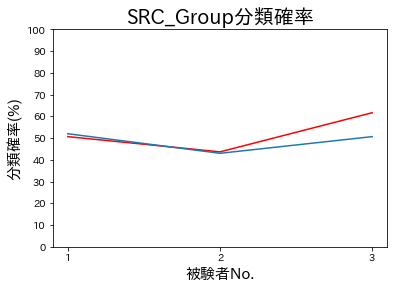

In [25]:
import matplotlib.pyplot as plt
import japanize_matplotlib
y = np.array([])
x = np.arange(1, 4, step=1)
y = np.append(p_average_1000Hz[:,0],y)
y = np.append(p_average_100Hz[:,0],y)
y = y.reshape([2,3])
print(y)
plt.plot(x,y[1],"red")
plt.plot(x,y[0])
plt.title("SRC_Group分類確率", {"fontsize":20})
plt.xlabel("被験者No.", {"fontsize":15})
plt.ylabel("分類確率(%)", {"fontsize":15})
plt.xticks(np.arange(1, 4, step=1))
plt.yticks(np.arange(0, 110, step=10))
plt.savefig("4a_SRC_group_probability_K3.pdf")
plt.show()

In [26]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_10/feat_left_A01T_10.txt","feat_2a_250Hz_10/feat_right_A01T_10.txt","feat_2a_250Hz_10/feat_test_left_A01E.txt","feat_2a_250Hz_10/feat_test_right_A01E.txt"
                           ,"feat_2a_250Hz_30/feat_left_A02T_30.txt","feat_2a_250Hz_30/feat_right_A02T_30.txt","feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_10/feat_left_A02T_10.txt","feat_2a_250Hz_10/feat_right_A02T_10.txt","feat_2a_250Hz_10/feat_test_left_A02E.txt","feat_2a_250Hz_10/feat_test_right_A02E.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_10/feat_left_A03T_10.txt","feat_2a_250Hz_10/feat_right_A03T_10.txt","feat_2a_250Hz_10/feat_test_left_A03E.txt","feat_2a_250Hz_10/feat_test_right_A03E.txt"
                           ,"feat_2a_250Hz_30/feat_left_A02T_30.txt","feat_2a_250Hz_30/feat_right_A02T_30.txt","feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_10/feat_left_A07T_10.txt","feat_2a_250Hz_10/feat_right_A07T_10.txt","feat_2a_250Hz_10/feat_test_left_A07E.txt","feat_2a_250Hz_10/feat_test_right_A07E.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_10/feat_left_A08T_10.txt","feat_2a_250Hz_10/feat_right_A08T_10.txt","feat_2a_250Hz_10/feat_test_left_A08E.txt","feat_2a_250Hz_10/feat_test_right_A08E.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_10/feat_left_A09T_10.txt","feat_2a_250Hz_10/feat_right_A09T_10.txt","feat_2a_250Hz_10/feat_test_left_A09E.txt","feat_2a_250Hz_10/feat_test_right_A09E.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A08T_30.txt","feat_2a_250Hz_30/feat_right_A08T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_1 = probability.reshape([6, 3])
df = pd.DataFrame(probability_1,columns=feature1,index=name1)
#df.to_csv("pandas_test.csv")
df

,全体,左,右
1,43.0,64.0,22.0
2,50.0,100.0,0.0
3,65.0,72.0,58.0
4,57.0,52.0,62.0
5,49.0,4.0,94.0
6,50.0,98.0,2.0


In [27]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_10/feat_left_A01T_10.txt","feat_2a_250Hz_10/feat_right_A01T_10.txt","feat_2a_250Hz_10/feat_test_left_A01E.txt","feat_2a_250Hz_10/feat_test_right_A01E.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A02T_30.txt","feat_2a_250Hz_30_2/feat_right_A02T_30.txt","feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_10/feat_left_A02T_10.txt","feat_2a_250Hz_10/feat_right_A02T_10.txt","feat_2a_250Hz_10/feat_test_left_A02E.txt","feat_2a_250Hz_10/feat_test_right_A02E.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_10/feat_left_A03T_10.txt","feat_2a_250Hz_10/feat_right_A03T_10.txt","feat_2a_250Hz_10/feat_test_left_A03E.txt","feat_2a_250Hz_10/feat_test_right_A03E.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A02T_30.txt","feat_2a_250Hz_30_2/feat_right_A02T_30.txt","feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_10/feat_left_A07T_10.txt","feat_2a_250Hz_10/feat_right_A07T_10.txt","feat_2a_250Hz_10/feat_test_left_A07E.txt","feat_2a_250Hz_10/feat_test_right_A07E.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_10/feat_left_A08T_10.txt","feat_2a_250Hz_10/feat_right_A08T_10.txt","feat_2a_250Hz_10/feat_test_left_A08E.txt","feat_2a_250Hz_10/feat_test_right_A08E.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_10/feat_left_A09T_10.txt","feat_2a_250Hz_10/feat_right_A09T_10.txt","feat_2a_250Hz_10/feat_test_left_A09E.txt","feat_2a_250Hz_10/feat_test_right_A09E.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A08T_30.txt","feat_2a_250Hz_30_2/feat_right_A08T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_2 = probability.reshape([6, 3])
df = pd.DataFrame(probability_2,columns=feature1,index=name1)
#df.to_csv("pandas_test.csv")
df

,全体,左,右
1,52.0,56.0,48.0
2,54.0,42.0,66.0
3,63.0,70.0,56.0
4,54.0,58.0,50.0
5,46.0,2.0,90.0
6,60.0,40.0,80.0


In [28]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_10/feat_left_A01T_10.txt","feat_2a_250Hz_10/feat_right_A01T_10.txt","feat_2a_250Hz_10/feat_test_left_A01E.txt","feat_2a_250Hz_10/feat_test_right_A01E.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A02T_30.txt","feat_2a_250Hz_30_3/feat_right_A02T_30.txt","feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_10/feat_left_A02T_10.txt","feat_2a_250Hz_10/feat_right_A02T_10.txt","feat_2a_250Hz_10/feat_test_left_A02E.txt","feat_2a_250Hz_10/feat_test_right_A02E.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_10/feat_left_A03T_10.txt","feat_2a_250Hz_10/feat_right_A03T_10.txt","feat_2a_250Hz_10/feat_test_left_A03E.txt","feat_2a_250Hz_10/feat_test_right_A03E.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A02T_30.txt","feat_2a_250Hz_30_3/feat_right_A02T_30.txt","feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_10/feat_left_A07T_10.txt","feat_2a_250Hz_10/feat_right_A07T_10.txt","feat_2a_250Hz_10/feat_test_left_A07E.txt","feat_2a_250Hz_10/feat_test_right_A07E.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_10/feat_left_A08T_10.txt","feat_2a_250Hz_10/feat_right_A08T_10.txt","feat_2a_250Hz_10/feat_test_left_A08E.txt","feat_2a_250Hz_10/feat_test_right_A08E.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_10/feat_left_A09T_10.txt","feat_2a_250Hz_10/feat_right_A09T_10.txt","feat_2a_250Hz_10/feat_test_left_A09E.txt","feat_2a_250Hz_10/feat_test_right_A09E.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A08T_30.txt","feat_2a_250Hz_30_3/feat_right_A08T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_3 = probability.reshape([6, 3])
df = pd.DataFrame(probability_3,columns=feature1,index=name1)
#df.to_csv("pandas_test.csv")
df

,全体,左,右
1,51.0,86.0,16.0
2,50.0,100.0,0.0
3,63.0,68.0,58.0
4,50.0,78.0,22.0
5,49.0,0.0,98.0
6,50.0,98.0,2.0


In [29]:
p_average_250Hz = (probability_1+probability_2+probability_3)/3
df = pd.DataFrame(p_average_250Hz,columns=feature1,index=name1)
#df.to_csv("pandas_test.csv")
df

,全体,左,右
1,48.7,68.7,28.7
2,51.3,80.7,22.0
3,63.7,70.0,57.3
4,53.7,62.7,44.7
5,48.0,2.0,94.0
6,53.3,78.7,28.0


In [30]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_10/feat_left_A01T_10.txt","feat_2a_125Hz_10/feat_right_A01T_10.txt","feat_2a_125Hz_10/feat_test_left_A01E.txt","feat_2a_125Hz_10/feat_test_right_A01E.txt"
                           ,"feat_2a_125Hz_30/feat_left_A02T_30.txt","feat_2a_125Hz_30/feat_right_A02T_30.txt","feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_10/feat_left_A02T_10.txt","feat_2a_125Hz_10/feat_right_A02T_10.txt","feat_2a_125Hz_10/feat_test_left_A02E.txt","feat_2a_125Hz_10/feat_test_right_A02E.txt"
                           ,"feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt","feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_10/feat_left_A03T_10.txt","feat_2a_125Hz_10/feat_right_A03T_10.txt","feat_2a_125Hz_10/feat_test_left_A03E.txt","feat_2a_125Hz_10/feat_test_right_A03E.txt"
                           ,"feat_2a_125Hz_30/feat_left_A02T_30.txt","feat_2a_125Hz_30/feat_right_A02T_30.txt","feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_10/feat_left_A07T_10.txt","feat_2a_125Hz_10/feat_right_A07T_10.txt","feat_2a_125Hz_10/feat_test_left_A07E.txt","feat_2a_125Hz_10/feat_test_right_A07E.txt"
                           ,"feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt","feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_10/feat_left_A08T_10.txt","feat_2a_125Hz_10/feat_right_A08T_10.txt","feat_2a_125Hz_10/feat_test_left_A08E.txt","feat_2a_125Hz_10/feat_test_right_A08E.txt"
                           ,"feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt","feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_10/feat_left_A09T_10.txt","feat_2a_125Hz_10/feat_right_A09T_10.txt","feat_2a_125Hz_10/feat_test_left_A09E.txt","feat_2a_125Hz_10/feat_test_right_A09E.txt"
                           ,"feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt","feat_2a_125Hz_30/feat_left_A08T_30.txt","feat_2a_125Hz_30/feat_right_A08T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_1 = probability.reshape([6, 3])
df = pd.DataFrame(probability_1,columns=feature1,index=name1)
#df.to_csv("pandas_test.csv")
df

,全体,左,右
1,48.0,54.0,42.0
2,63.0,60.0,66.0
3,51.0,66.0,36.0
4,46.0,38.0,54.0
5,49.0,12.0,86.0
6,56.0,16.0,96.0


In [31]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_10/feat_left_A01T_10.txt","feat_2a_125Hz_10/feat_right_A01T_10.txt","feat_2a_125Hz_10/feat_test_left_A01E.txt","feat_2a_125Hz_10/feat_test_right_A01E.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A02T_30.txt","feat_2a_125Hz_30_2/feat_right_A02T_30.txt","feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_10/feat_left_A02T_10.txt","feat_2a_125Hz_10/feat_right_A02T_10.txt","feat_2a_125Hz_10/feat_test_left_A02E.txt","feat_2a_125Hz_10/feat_test_right_A02E.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_10/feat_left_A03T_10.txt","feat_2a_125Hz_10/feat_right_A03T_10.txt","feat_2a_125Hz_10/feat_test_left_A03E.txt","feat_2a_125Hz_10/feat_test_right_A03E.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A02T_30.txt","feat_2a_125Hz_30_2/feat_right_A02T_30.txt","feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_10/feat_left_A07T_10.txt","feat_2a_125Hz_10/feat_right_A07T_10.txt","feat_2a_125Hz_10/feat_test_left_A07E.txt","feat_2a_125Hz_10/feat_test_right_A07E.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_10/feat_left_A08T_10.txt","feat_2a_125Hz_10/feat_right_A08T_10.txt","feat_2a_125Hz_10/feat_test_left_A08E.txt","feat_2a_125Hz_10/feat_test_right_A08E.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_10/feat_left_A09T_10.txt","feat_2a_125Hz_10/feat_right_A09T_10.txt","feat_2a_125Hz_10/feat_test_left_A09E.txt","feat_2a_125Hz_10/feat_test_right_A09E.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A06T_30.txt","feat_2a_125Hz_30_2/feat_right_A06T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_2 = probability.reshape([6, 3])
df = pd.DataFrame(probability_2,columns=feature1,index=name1)
#df.to_csv("pandas_test.csv")
df

,全体,左,右
1,34.0,24.0,44.0
2,53.0,72.0,34.0
3,47.0,80.0,14.0
4,49.0,72.0,26.0
5,56.0,30.0,82.0
6,57.0,34.0,80.0


In [32]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_10/feat_left_A01T_10.txt","feat_2a_125Hz_10/feat_right_A01T_10.txt","feat_2a_125Hz_10/feat_test_left_A01E.txt","feat_2a_125Hz_10/feat_test_right_A01E.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A02T_30.txt","feat_2a_125Hz_30_3/feat_right_A02T_30.txt","feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_10/feat_left_A02T_10.txt","feat_2a_125Hz_10/feat_right_A02T_10.txt","feat_2a_125Hz_10/feat_test_left_A02E.txt","feat_2a_125Hz_10/feat_test_right_A02E.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_10/feat_left_A03T_10.txt","feat_2a_125Hz_10/feat_right_A03T_10.txt","feat_2a_125Hz_10/feat_test_left_A03E.txt","feat_2a_125Hz_10/feat_test_right_A03E.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A02T_30.txt","feat_2a_125Hz_30_3/feat_right_A02T_30.txt","feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_10/feat_left_A07T_10.txt","feat_2a_125Hz_10/feat_right_A07T_10.txt","feat_2a_125Hz_10/feat_test_left_A07E.txt","feat_2a_125Hz_10/feat_test_right_A07E.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_10/feat_left_A08T_10.txt","feat_2a_125Hz_10/feat_right_A08T_10.txt","feat_2a_125Hz_10/feat_test_left_A08E.txt","feat_2a_125Hz_10/feat_test_right_A08E.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_125Hz_10/feat_left_A09T_10.txt","feat_2a_125Hz_10/feat_right_A09T_10.txt","feat_2a_125Hz_10/feat_test_left_A09E.txt","feat_2a_125Hz_10/feat_test_right_A09E.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A08T_30.txt","feat_2a_125Hz_30_3/feat_right_A08T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_3 = probability.reshape([6, 3])
df = pd.DataFrame(probability_3,columns=feature1,index=name1)
#df.to_csv("pandas_test.csv")
df

,全体,左,右
1,49.0,98.0,0.0
2,55.0,66.0,44.0
3,57.0,34.0,80.0
4,55.0,86.0,24.0
5,53.0,8.0,98.0
6,52.0,24.0,80.0


In [33]:
p_average_125Hz = (probability_1+probability_2+probability_3)/3
df = pd.DataFrame(p_average_125Hz,columns=feature1,index=name1)
#df.to_csv("pandas_test.csv")
df

,全体,左,右
1,43.7,58.7,28.7
2,57.0,66.0,48.0
3,51.7,60.0,43.3
4,50.0,65.3,34.7
5,52.7,16.7,88.7
6,55.0,24.7,85.3


In [34]:
a_20 = 0; a_30 = 0;
for i in range(6):
    a_20 = a_20 + p_average_250Hz[i,0] 
    a_30 = a_30 + p_average_125Hz[i,0] 
    
a_20 = a_20/6
a_30 = a_30/6
print(a_20,a_30)

53.11111111111111 51.666666666666664


[[43.66666667 57.         51.66666667 50.         52.66666667 55.        ]
 [48.66666667 51.33333333 63.66666667 53.66666667 48.         53.33333333]]


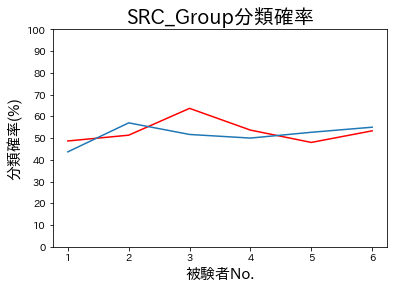

In [35]:
import matplotlib.pyplot as plt
import japanize_matplotlib
y = np.array([])
x = np.arange(1, 7, step=1)
y = np.append(p_average_250Hz[:,0],y)
y = np.append(p_average_125Hz[:,0],y)
y = y.reshape([2,6])
print(y)
plt.plot(x,y[1],"red")
plt.plot(x,y[0])
plt.title("SRC_Group分類確率", {"fontsize":20})
plt.xlabel("被験者No.", {"fontsize":15})
plt.ylabel("分類確率(%)", {"fontsize":15})
plt.xticks(np.arange(1, 7, step=1))
plt.yticks(np.arange(0, 110, step=10))
plt.savefig("2a_SRC_group_probability_K3_down.pdf")
plt.show()

In [36]:
#train=30,test=50で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_4a_1000Hz_10/feat_right_aa_10.txt","feat_4a_1000Hz_10/feat_foot_aa_10.txt","feat_4a_1000Hz_10/feat_test_right_aa.txt","feat_4a_1000Hz_10/feat_test_foot_aa.txt"
                           ,"feat_4a_1000Hz_30/feat_right_av_30.txt","feat_4a_1000Hz_30/feat_foot_av_30.txt","feat_4a_1000Hz_30/feat_right_al_30.txt","feat_4a_1000Hz_30/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30/feat_right_aw_30.txt","feat_4a_1000Hz_30/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_4a_1000Hz_10/feat_right_av_10.txt","feat_4a_1000Hz_10/feat_foot_av_10.txt","feat_4a_1000Hz_10/feat_test_right_av.txt","feat_4a_1000Hz_10/feat_test_foot_av.txt"
                           ,"feat_4a_1000Hz_30/feat_right_aa_30.txt","feat_4a_1000Hz_30/feat_foot_aa_30.txt","feat_4a_1000Hz_30/feat_right_al_30.txt","feat_4a_1000Hz_30/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30/feat_right_aw_30.txt","feat_4a_1000Hz_30/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_4a_1000Hz_10/feat_right_aw_10.txt","feat_4a_1000Hz_10/feat_foot_aw_10.txt","feat_4a_1000Hz_10/feat_test_right_aw.txt","feat_4a_1000Hz_10/feat_test_foot_aw.txt"
                           ,"feat_4a_1000Hz_30/feat_right_aa_30.txt","feat_4a_1000Hz_30/feat_foot_aa_30.txt","feat_4a_1000Hz_30/feat_right_al_30.txt","feat_4a_1000Hz_30/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30/feat_right_av_30.txt","feat_4a_1000Hz_30/feat_foot_av_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_1 = probability.reshape([3, 3])
df = pd.DataFrame(probability_1,columns=feature2,index=name2)
#df.to_csv("pandas_test.csv")
df

,全体,右,足
1,43.0,44.0,42.0
2,49.0,40.0,58.0
3,52.0,90.0,14.0


In [37]:
#train=30,test=50で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_4a_1000Hz_10/feat_right_aa_10.txt","feat_4a_1000Hz_10/feat_foot_aa_10.txt","feat_4a_1000Hz_10/feat_test_right_aa.txt","feat_4a_1000Hz_10/feat_test_foot_aa.txt"
                           ,"feat_4a_1000Hz_30_2/feat_right_av_30.txt","feat_4a_1000Hz_30_2/feat_foot_av_30.txt","feat_4a_1000Hz_30_2/feat_right_al_30.txt","feat_4a_1000Hz_30_2/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30_2/feat_right_aw_30.txt","feat_4a_1000Hz_30_2/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_4a_1000Hz_10/feat_right_av_10.txt","feat_4a_1000Hz_10/feat_foot_av_10.txt","feat_4a_1000Hz_10/feat_test_right_av.txt","feat_4a_1000Hz_10/feat_test_foot_av.txt"
                           ,"feat_4a_1000Hz_30_2/feat_right_aa_30.txt","feat_4a_1000Hz_30_2/feat_foot_aa_30.txt","feat_4a_1000Hz_30_2/feat_right_al_30.txt","feat_4a_1000Hz_30_2/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30_2/feat_right_aw_30.txt","feat_4a_1000Hz_30_2/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_4a_1000Hz_10/feat_right_aw_10.txt","feat_4a_1000Hz_10/feat_foot_aw_10.txt","feat_4a_1000Hz_10/feat_test_right_aw.txt","feat_4a_1000Hz_10/feat_test_foot_aw.txt"
                           ,"feat_4a_1000Hz_30_2/feat_right_aa_30.txt","feat_4a_1000Hz_30_2/feat_foot_aa_30.txt","feat_4a_1000Hz_30_2/feat_right_al_30.txt","feat_4a_1000Hz_30_2/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30_2/feat_right_av_30.txt","feat_4a_1000Hz_30_2/feat_foot_av_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_2 = probability.reshape([3, 3])
df = pd.DataFrame(probability_2,columns=feature2,index=name2)
#df.to_csv("pandas_test.csv")
df

,全体,右,足
1,45.0,44.0,46.0
2,53.0,60.0,46.0
3,48.0,60.0,36.0


In [38]:
#train=30,test=50で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_4a_1000Hz_10/feat_right_aa_10.txt","feat_4a_1000Hz_10/feat_foot_aa_10.txt","feat_4a_1000Hz_10/feat_test_right_aa.txt","feat_4a_1000Hz_10/feat_test_foot_aa.txt"
                           ,"feat_4a_1000Hz_30_3/feat_right_av_30.txt","feat_4a_1000Hz_30_3/feat_foot_av_30.txt","feat_4a_1000Hz_30_3/feat_right_al_30.txt","feat_4a_1000Hz_30_3/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30_3/feat_right_aw_30.txt","feat_4a_1000Hz_30_3/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_4a_1000Hz_10/feat_right_av_10.txt","feat_4a_1000Hz_10/feat_foot_av_10.txt","feat_4a_1000Hz_10/feat_test_right_av.txt","feat_4a_1000Hz_10/feat_test_foot_av.txt"
                           ,"feat_4a_1000Hz_30_3/feat_right_aa_30.txt","feat_4a_1000Hz_30_3/feat_foot_aa_30.txt","feat_4a_1000Hz_30_3/feat_right_al_30.txt","feat_4a_1000Hz_30_3/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30_3/feat_right_aw_30.txt","feat_4a_1000Hz_30_3/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_4a_1000Hz_10/feat_right_aw_10.txt","feat_4a_1000Hz_10/feat_foot_aw_10.txt","feat_4a_1000Hz_10/feat_test_right_aw.txt","feat_4a_1000Hz_10/feat_test_foot_aw.txt"
                           ,"feat_4a_1000Hz_30_3/feat_right_aa_30.txt","feat_4a_1000Hz_30_3/feat_foot_aa_30.txt","feat_4a_1000Hz_30_3/feat_right_al_30.txt","feat_4a_1000Hz_30_3/feat_foot_al_30.txt"
                           ,"feat_4a_1000Hz_30_3/feat_right_av_30.txt","feat_4a_1000Hz_30_3/feat_foot_av_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_3 = probability.reshape([3, 3])
df = pd.DataFrame(probability_3,columns=feature2,index=name2)
#df.to_csv("pandas_test.csv")
df

,全体,右,足
1,47.0,46.0,48.0
2,61.0,58.0,64.0
3,56.0,82.0,30.0


In [39]:
p_average_1000Hz = (probability_1+probability_2+probability_3)/3
df = pd.DataFrame(p_average_1000Hz,columns=feature2,index=name2)
#df.to_csv("pandas_test.csv")
df

,全体,右,足
1,45.0,44.7,45.3
2,54.3,52.7,56.0
3,52.0,77.3,26.7


In [40]:
#train=30,test=50で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_4a_100Hz_10/feat_right_aa_10.txt","feat_4a_100Hz_10/feat_foot_aa_10.txt","feat_4a_100Hz_10/feat_test_right_aa.txt","feat_4a_100Hz_10/feat_test_foot_aa.txt"
                           ,"feat_4a_100Hz_30/feat_right_av_30.txt","feat_4a_100Hz_30/feat_foot_av_30.txt","feat_4a_100Hz_30/feat_right_al_30.txt","feat_4a_100Hz_30/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30/feat_right_aw_30.txt","feat_4a_100Hz_30/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_4a_100Hz_10/feat_right_av_10.txt","feat_4a_100Hz_10/feat_foot_av_10.txt","feat_4a_100Hz_10/feat_test_right_av.txt","feat_4a_100Hz_10/feat_test_foot_av.txt"
                           ,"feat_4a_100Hz_30/feat_right_aa_30.txt","feat_4a_100Hz_30/feat_foot_aa_30.txt","feat_4a_100Hz_30/feat_right_al_30.txt","feat_4a_100Hz_30/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30/feat_right_aw_30.txt","feat_4a_100Hz_30/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_4a_100Hz_10/feat_right_aw_10.txt","feat_4a_100Hz_10/feat_foot_aw_10.txt","feat_4a_100Hz_10/feat_test_right_aw.txt","feat_4a_100Hz_10/feat_test_foot_aw.txt"
                           ,"feat_4a_100Hz_30/feat_right_aa_30.txt","feat_4a_100Hz_30/feat_foot_aa_30.txt","feat_4a_100Hz_30/feat_right_al_30.txt","feat_4a_100Hz_30/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30/feat_right_av_30.txt","feat_4a_100Hz_30/feat_foot_av_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_1 = probability.reshape([3, 3])
df = pd.DataFrame(probability_1,columns=feature2,index=name2)
#df.to_csv("pandas_test.csv")
df

,全体,右,足
1,52.0,48.0,56.0
2,51.0,58.0,44.0
3,59.0,74.0,44.0


In [41]:
#train=30,test=50で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_4a_100Hz_10/feat_right_aa_10.txt","feat_4a_100Hz_10/feat_foot_aa_10.txt","feat_4a_100Hz_10/feat_test_right_aa.txt","feat_4a_100Hz_10/feat_test_foot_aa.txt"
                           ,"feat_4a_100Hz_30_2/feat_right_av_30.txt","feat_4a_100Hz_30_2/feat_foot_av_30.txt","feat_4a_100Hz_30_2/feat_right_al_30.txt","feat_4a_100Hz_30_2/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30_2/feat_right_aw_30.txt","feat_4a_100Hz_30_2/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_4a_100Hz_10/feat_right_av_10.txt","feat_4a_100Hz_10/feat_foot_av_10.txt","feat_4a_100Hz_10/feat_test_right_av.txt","feat_4a_100Hz_10/feat_test_foot_av.txt"
                           ,"feat_4a_100Hz_30_2/feat_right_aa_30.txt","feat_4a_100Hz_30_2/feat_foot_aa_30.txt","feat_4a_100Hz_30_2/feat_right_al_30.txt","feat_4a_100Hz_30_2/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30_2/feat_right_aw_30.txt","feat_4a_100Hz_30_2/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_4a_100Hz_10/feat_right_aw_10.txt","feat_4a_100Hz_10/feat_foot_aw_10.txt","feat_4a_100Hz_10/feat_test_right_aw.txt","feat_4a_100Hz_10/feat_test_foot_aw.txt"
                           ,"feat_4a_100Hz_30_2/feat_right_aa_30.txt","feat_4a_100Hz_30_2/feat_foot_aa_30.txt","feat_4a_100Hz_30_2/feat_right_al_30.txt","feat_4a_100Hz_30_2/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30_2/feat_right_av_30.txt","feat_4a_100Hz_30_2/feat_foot_av_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_2 = probability.reshape([3, 3])
df = pd.DataFrame(probability_2,columns=feature2,index=name2)
#df.to_csv("pandas_test.csv")
df

,全体,右,足
1,56.0,42.0,70.0
2,55.0,48.0,62.0
3,58.0,74.0,42.0


In [42]:
#train=30,test=50で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_4a_100Hz_10/feat_right_aa_10.txt","feat_4a_100Hz_10/feat_foot_aa_10.txt","feat_4a_100Hz_10/feat_test_right_aa.txt","feat_4a_100Hz_10/feat_test_foot_aa.txt"
                           ,"feat_4a_100Hz_30_3/feat_right_av_30.txt","feat_4a_100Hz_30_3/feat_foot_av_30.txt","feat_4a_100Hz_30_3/feat_right_al_30.txt","feat_4a_100Hz_30_3/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30_3/feat_right_aw_30.txt","feat_4a_100Hz_30_3/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_4a_100Hz_10/feat_right_av_10.txt","feat_4a_100Hz_10/feat_foot_av_10.txt","feat_4a_100Hz_10/feat_test_right_av.txt","feat_4a_100Hz_10/feat_test_foot_av.txt"
                           ,"feat_4a_100Hz_30_3/feat_right_aa_30.txt","feat_4a_100Hz_30_3/feat_foot_aa_30.txt","feat_4a_100Hz_30_3/feat_right_al_30.txt","feat_4a_100Hz_30_3/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30_3/feat_right_aw_30.txt","feat_4a_100Hz_30_3/feat_foot_aw_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_4a_100Hz_10/feat_right_aw_10.txt","feat_4a_100Hz_10/feat_foot_aw_10.txt","feat_4a_100Hz_10/feat_test_right_aw.txt","feat_4a_100Hz_10/feat_test_foot_aw.txt"
                           ,"feat_4a_100Hz_30_3/feat_right_aa_30.txt","feat_4a_100Hz_30_3/feat_foot_aa_30.txt","feat_4a_100Hz_30_3/feat_right_al_30.txt","feat_4a_100Hz_30_3/feat_foot_al_30.txt"
                           ,"feat_4a_100Hz_30_3/feat_right_av_30.txt","feat_4a_100Hz_30_3/feat_foot_av_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_3 = probability.reshape([3, 3])
df = pd.DataFrame(probability_3,columns=feature2,index=name2)
#df.to_csv("pandas_test.csv")
df

,全体,右,足
1,56.0,62.0,50.0
2,45.0,2.0,88.0
3,64.0,54.0,74.0


In [43]:
p_average_100Hz = (probability_1+probability_2+probability_3)/3
df = pd.DataFrame(p_average_100Hz,columns=feature2,index=name2)
#df.to_csv("pandas_test.csv")
df

,全体,右,足
1,54.7,50.7,58.7
2,50.3,36.0,64.7
3,60.3,67.3,53.3


In [44]:
a_20 = 0; a_30 = 0;
for i in range(3):
    a_20 = a_20 + p_average_1000Hz[i,0] 
    a_30 = a_30 + p_average_100Hz[i,0] 
    
a_20 = a_20/3
a_30 = a_30/3
print(a_20,a_30)

50.44444444444445 55.111111111111114


[[54.66666667 50.33333333 60.33333333]
 [45.         54.33333333 52.        ]]


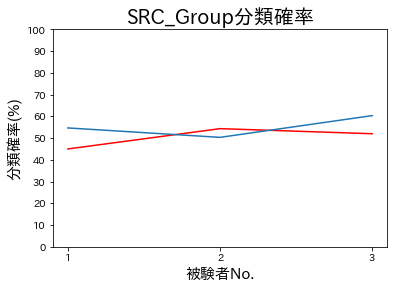

In [45]:
import matplotlib.pyplot as plt
import japanize_matplotlib
y = np.array([])
x = np.arange(1, 4, step=1)
y = np.append(p_average_1000Hz[:,0],y)
y = np.append(p_average_100Hz[:,0],y)
y = y.reshape([2,3])
print(y)
plt.plot(x,y[1],"red")
plt.plot(x,y[0])
plt.title("SRC_Group分類確率", {"fontsize":20})
plt.xlabel("被験者No.", {"fontsize":15})
plt.ylabel("分類確率(%)", {"fontsize":15})
plt.xticks(np.arange(1, 4, step=1))
plt.yticks(np.arange(0, 110, step=10))
plt.savefig("4a_SRC_group_probability_K3_10.pdf")
plt.show()

In [64]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("emotiv_data/feat_left_emotiv_20.txt","emotiv_data/feat_right_emotiv_20.txt","emotiv_data/feat_test_left_emotiv_20.txt","emotiv_data/feat_test_right_emotiv_20.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("emotiv_data_2/feat_left_emotiv_20.txt","emotiv_data_2/feat_right_emotiv_20.txt","emotiv_data_2/feat_test_left_emotiv_20.txt","emotiv_data_2/feat_test_right_emotiv_20.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("emotiv_data_3/feat_left_emotiv_20.txt","emotiv_data_3/feat_right_emotiv_20.txt","emotiv_data_3/feat_test_left_emotiv_20.txt","emotiv_data_3/feat_test_right_emotiv_20.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
probability_1 = probability.reshape([3, 3])
df = pd.DataFrame(probability_1,columns=feature1,index=name2)
#df.to_csv("pandas_test.csv")
df

,全体,左,右
1,52.0,66.0,38.0
2,54.0,28.0,80.0
3,50.0,94.0,6.0


In [65]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("emotiv_data/feat_left_emotiv_20.txt","emotiv_data/feat_right_emotiv_20.txt","emotiv_data/feat_test_left_emotiv_20.txt","emotiv_data/feat_test_right_emotiv_20.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("emotiv_data_2/feat_left_emotiv_20.txt","emotiv_data_2/feat_right_emotiv_20.txt","emotiv_data_2/feat_test_left_emotiv_20.txt","emotiv_data_2/feat_test_right_emotiv_20.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("emotiv_data_3/feat_left_emotiv_20.txt","emotiv_data_3/feat_right_emotiv_20.txt","emotiv_data_3/feat_test_left_emotiv_20.txt","emotiv_data_3/feat_test_right_emotiv_20.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_2 = probability.reshape([3, 3])
df = pd.DataFrame(probability_2,columns=feature1,index=name2)
#df.to_csv("pandas_test.csv")
df

,全体,左,右
1,51.0,66.0,36.0
2,51.0,16.0,86.0
3,50.0,94.0,6.0


In [66]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("emotiv_data/feat_left_emotiv_20.txt","emotiv_data/feat_right_emotiv_20.txt","emotiv_data/feat_test_left_emotiv_20.txt","emotiv_data/feat_test_right_emotiv_20.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("emotiv_data_2/feat_left_emotiv_20.txt","emotiv_data_2/feat_right_emotiv_20.txt","emotiv_data_2/feat_test_left_emotiv_20.txt","emotiv_data_2/feat_test_right_emotiv_20.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("emotiv_data_3/feat_left_emotiv_20.txt","emotiv_data_3/feat_right_emotiv_20.txt","emotiv_data_3/feat_test_left_emotiv_20.txt","emotiv_data_3/feat_test_right_emotiv_20.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
probability_3 = probability.reshape([3, 3])
df = pd.DataFrame(probability_3,columns=feature1,index=name2)
#df.to_csv("pandas_test.csv")
df

,全体,左,右
1,53.0,68.0,38.0
2,54.0,32.0,76.0
3,49.0,92.0,6.0


In [67]:
p_average_250Hz = (probability_1+probability_2+probability_3)/3
df = pd.DataFrame(p_average_250Hz,columns=feature1,index=name2)
#df.to_csv("pandas_test.csv")
df

,全体,左,右
1,52.0,66.7,37.3
2,53.0,25.3,80.7
3,49.7,93.3,6.0


In [68]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("emotiv_data/feat_left_emotiv_20.txt","emotiv_data/feat_right_emotiv_20.txt","emotiv_data/feat_test_left_emotiv_20.txt","emotiv_data/feat_test_right_emotiv_20.txt"
                           ,"feat_2a_125Hz_30/feat_left_A02T_30.txt","feat_2a_125Hz_30/feat_right_A02T_30.txt","feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("emotiv_data_2/feat_left_emotiv_20.txt","emotiv_data_2/feat_right_emotiv_20.txt","emotiv_data_2/feat_test_left_emotiv_20.txt","emotiv_data_2/feat_test_right_emotiv_20.txt"
                           ,"feat_2a_125Hz_30/feat_left_A02T_30.txt","feat_2a_125Hz_30/feat_right_A02T_30.txt","feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("emotiv_data_3/feat_left_emotiv_20.txt","emotiv_data_3/feat_right_emotiv_20.txt","emotiv_data_3/feat_test_left_emotiv_20.txt","emotiv_data_3/feat_test_right_emotiv_20.txt"
                           ,"feat_2a_125Hz_30/feat_left_A02T_30.txt","feat_2a_125Hz_30/feat_right_A02T_30.txt","feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_1 = probability.reshape([3, 3])
df = pd.DataFrame(probability_1,columns=feature1,index=name2)
#df.to_csv("pandas_test.csv")
df

,全体,左,右
1,49.0,28.0,70.0
2,50.0,16.0,84.0
3,50.0,100.0,0.0


In [69]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("emotiv_data/feat_left_emotiv_20.txt","emotiv_data/feat_right_emotiv_20.txt","emotiv_data/feat_test_left_emotiv_20.txt","emotiv_data/feat_test_right_emotiv_20.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("emotiv_data_2/feat_left_emotiv_20.txt","emotiv_data_2/feat_right_emotiv_20.txt","emotiv_data_2/feat_test_left_emotiv_20.txt","emotiv_data_2/feat_test_right_emotiv_20.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("emotiv_data_3/feat_left_emotiv_20.txt","emotiv_data_3/feat_right_emotiv_20.txt","emotiv_data_3/feat_test_left_emotiv_20.txt","emotiv_data_3/feat_test_right_emotiv_20.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
probability_2 = probability.reshape([3, 3])
df = pd.DataFrame(probability_2,columns=feature1,index=name2)
#df.to_csv("pandas_test.csv")
df

,全体,左,右
1,53.0,68.0,38.0
2,60.0,54.0,66.0
3,50.0,94.0,6.0


In [70]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("emotiv_data/feat_left_emotiv_20.txt","emotiv_data/feat_right_emotiv_20.txt","emotiv_data/feat_test_left_emotiv_20.txt","emotiv_data/feat_test_right_emotiv_20.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("emotiv_data_2/feat_left_emotiv_20.txt","emotiv_data_2/feat_right_emotiv_20.txt","emotiv_data_2/feat_test_left_emotiv_20.txt","emotiv_data_2/feat_test_right_emotiv_20.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("emotiv_data_3/feat_left_emotiv_20.txt","emotiv_data_3/feat_right_emotiv_20.txt","emotiv_data_3/feat_test_left_emotiv_20.txt","emotiv_data_3/feat_test_right_emotiv_20.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
probability_3 = probability.reshape([3, 3])
df = pd.DataFrame(probability_3,columns=feature1,index=name2)
#df.to_csv("pandas_test.csv")
df
        

,全体,左,右
1,51.0,72.0,30.0
2,56.0,38.0,74.0
3,50.0,94.0,6.0


In [71]:
p_average_125Hz = (probability_1+probability_2+probability_3)/3
df = pd.DataFrame(p_average_125Hz,columns=feature1,index=name2)
#df.to_csv("pandas_test.csv")
df

,全体,左,右
1,51.0,56.0,46.0
2,55.3,36.0,74.7
3,50.0,96.0,4.0


In [72]:
a_20 = 0; a_30 = 0;
for i in range(2):
    a_20 = a_20 + p_average_250Hz[i,0] 
    a_30 = a_30 + p_average_125Hz[i,0] 
    
a_20 = a_20/2
a_30 = a_30/2
print(a_20,a_30)

52.5 53.16666666666667


In [73]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("emotiv_data/feat_left_emotiv_10.txt","emotiv_data/feat_right_emotiv_10.txt","emotiv_data/feat_test_left_emotiv_10.txt","emotiv_data/feat_test_right_emotiv_10.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("emotiv_data_2/feat_left_emotiv_10.txt","emotiv_data_2/feat_right_emotiv_10.txt","emotiv_data_2/feat_test_left_emotiv_10.txt","emotiv_data_2/feat_test_right_emotiv_10.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("emotiv_data_3/feat_left_emotiv_10.txt","emotiv_data_3/feat_right_emotiv_10.txt","emotiv_data_3/feat_test_left_emotiv_10.txt","emotiv_data_3/feat_test_right_emotiv_10.txt"
                           ,"feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
probability_1 = probability.reshape([3, 3])
df = pd.DataFrame(probability_1,columns=feature1,index=name2)
#df.to_csv("pandas_test.csv")
df

,全体,左,右
1,55.0,90.0,20.0
2,49.0,48.0,50.0
3,53.0,26.0,80.0


In [74]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("emotiv_data/feat_left_emotiv_10.txt","emotiv_data/feat_right_emotiv_10.txt","emotiv_data/feat_test_left_emotiv_10.txt","emotiv_data/feat_test_right_emotiv_10.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("emotiv_data_2/feat_left_emotiv_10.txt","emotiv_data_2/feat_right_emotiv_10.txt","emotiv_data_2/feat_test_left_emotiv_10.txt","emotiv_data_2/feat_test_right_emotiv_10.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("emotiv_data_3/feat_left_emotiv_10.txt","emotiv_data_3/feat_right_emotiv_10.txt","emotiv_data_3/feat_test_left_emotiv_10.txt","emotiv_data_3/feat_test_right_emotiv_10.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
probability_2 = probability.reshape([3, 3])
df = pd.DataFrame(probability_2,columns=feature1,index=name2)
#df.to_csv("pandas_test.csv")
df

,全体,左,右
1,54.0,88.0,20.0
2,50.0,2.0,98.0
3,54.0,26.0,82.0


In [75]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("emotiv_data/feat_left_emotiv_10.txt","emotiv_data/feat_right_emotiv_10.txt","emotiv_data/feat_test_left_emotiv_10.txt","emotiv_data/feat_test_right_emotiv_10.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("emotiv_data_2/feat_left_emotiv_10.txt","emotiv_data_2/feat_right_emotiv_10.txt","emotiv_data_2/feat_test_left_emotiv_10.txt","emotiv_data_2/feat_test_right_emotiv_10.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("emotiv_data_3/feat_left_emotiv_10.txt","emotiv_data_3/feat_right_emotiv_10.txt","emotiv_data_3/feat_test_left_emotiv_10.txt","emotiv_data_3/feat_test_right_emotiv_10.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
probability_3 = probability.reshape([3, 3])
df = pd.DataFrame(probability_3,columns=feature1,index=name2)
#df.to_csv("pandas_test.csv")
df

,全体,左,右
1,52.0,90.0,14.0
2,51.0,96.0,6.0
3,53.0,18.0,88.0


In [76]:
p_average_250Hz = (probability_1+probability_2+probability_3)/3
df = pd.DataFrame(p_average_250Hz,columns=feature1,index=name2)
#df.to_csv("pandas_test.csv")
df

,全体,左,右
1,53.7,89.3,18.0
2,50.0,48.7,51.3
3,53.3,23.3,83.3


In [77]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("emotiv_data/feat_left_emotiv_10.txt","emotiv_data/feat_right_emotiv_10.txt","emotiv_data/feat_test_left_emotiv_10.txt","emotiv_data/feat_test_right_emotiv_10.txt"
                           ,"feat_2a_125Hz_30/feat_left_A02T_30.txt","feat_2a_125Hz_30/feat_right_A02T_30.txt","feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("emotiv_data_2/feat_left_emotiv_10.txt","emotiv_data_2/feat_right_emotiv_10.txt","emotiv_data_2/feat_test_left_emotiv_10.txt","emotiv_data_2/feat_test_right_emotiv_10.txt"
                           ,"feat_2a_125Hz_30/feat_left_A02T_30.txt","feat_2a_125Hz_30/feat_right_A02T_30.txt","feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("emotiv_data_3/feat_left_emotiv_10.txt","emotiv_data_3/feat_right_emotiv_10.txt","emotiv_data_3/feat_test_left_emotiv_10.txt","emotiv_data_3/feat_test_right_emotiv_10.txt"
                           ,"feat_2a_125Hz_30/feat_left_A02T_30.txt","feat_2a_125Hz_30/feat_right_A02T_30.txt","feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
probability_1 = probability.reshape([3, 3])
df = pd.DataFrame(probability_1,columns=feature1,index=name2)
#df.to_csv("pandas_test.csv")
df

,全体,左,右
1,54.0,92.0,16.0
2,52.0,22.0,82.0
3,50.0,14.0,86.0


In [78]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("emotiv_data/feat_left_emotiv_10.txt","emotiv_data/feat_right_emotiv_10.txt","emotiv_data/feat_test_left_emotiv_10.txt","emotiv_data/feat_test_right_emotiv_10.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("emotiv_data_2/feat_left_emotiv_10.txt","emotiv_data_2/feat_right_emotiv_10.txt","emotiv_data_2/feat_test_left_emotiv_10.txt","emotiv_data_2/feat_test_right_emotiv_10.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("emotiv_data_3/feat_left_emotiv_10.txt","emotiv_data_3/feat_right_emotiv_10.txt","emotiv_data_3/feat_test_left_emotiv_10.txt","emotiv_data_3/feat_test_right_emotiv_10.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
probability_2 = probability.reshape([3, 3])
df = pd.DataFrame(probability_2,columns=feature1,index=name2)
#df.to_csv("pandas_test.csv")
df

,全体,左,右
1,54.0,90.0,18.0
2,50.0,18.0,82.0
3,55.0,32.0,78.0


In [79]:
#train=30,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("emotiv_data/feat_left_emotiv_10.txt","emotiv_data/feat_right_emotiv_10.txt","emotiv_data/feat_test_left_emotiv_10.txt","emotiv_data/feat_test_right_emotiv_10.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("emotiv_data_2/feat_left_emotiv_10.txt","emotiv_data_2/feat_right_emotiv_10.txt","emotiv_data_2/feat_test_left_emotiv_10.txt","emotiv_data_2/feat_test_right_emotiv_10.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("emotiv_data_3/feat_left_emotiv_10.txt","emotiv_data_3/feat_right_emotiv_10.txt","emotiv_data_3/feat_test_left_emotiv_10.txt","emotiv_data_3/feat_test_right_emotiv_10.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
probability_3 = probability.reshape([3, 3])
df = pd.DataFrame(probability_3,columns=feature1,index=name2)
#df.to_csv("pandas_test.csv")
df
        

,全体,左,右
1,54.0,92.0,16.0
2,49.0,72.0,26.0
3,55.0,34.0,76.0


In [80]:
p_average_125Hz = (probability_1+probability_2+probability_3)/3
df = pd.DataFrame(p_average_125Hz,columns=feature1,index=name2)
#df.to_csv("pandas_test.csv")
df

,全体,左,右
1,54.0,91.3,16.7
2,50.3,37.3,63.3
3,53.3,26.7,80.0


In [81]:
a_20 = 0; a_30 = 0;
for i in range(2):
    a_20 = a_20 + p_average_250Hz[i,0] 
    a_30 = a_30 + p_average_125Hz[i,0] 
    
a_20 = a_20/2
a_30 = a_30/2
print(a_20,a_30)

51.83333333333333 52.16666666666667
